In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

In [2]:
import matplotlib

%matplotlib inline

In [3]:
def get_data(batch_size: int):
    transform = transforms.ToTensor()
    train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader 

def train_step(model, criterion, optimizer, batch):
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    preds = model(images)
    loss = criterion(preds, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


class LiveLossPlotter:
    """Real-time loss plotting during training"""
    def __init__(self, update_freq=10, window_size=100):
        import matplotlib.pyplot as plt
        import numpy as np
        self.plt = plt
        self.np = np
        self.update_freq = update_freq  # Update plot every N steps
        self.window_size = window_size
        self.losses = []
        self.steps = []
        
        # Enable interactive mode
        self.plt.ion()
        
        # Create figure with two subplots
        self.fig, (self.ax1, self.ax2) = self.plt.subplots(1, 2, figsize=(12, 5))
        self.line1 = None
        self.line2 = None
        self.line_avg = None
        
    def update(self, loss, step):
        """Update the plot with new loss value"""
        self.losses.append(loss)
        self.steps.append(step)
        
        # Only update plot every update_freq steps to avoid lag
        if len(self.losses) % self.update_freq == 0 or len(self.losses) == 1:
            self._redraw()
    
    def _redraw(self):
        """Redraw the plot with current data"""
        # Clear and update left subplot (raw + moving average)
        self.ax1.clear()
        self.ax1.plot(self.steps, self.losses, alpha=0.3, color='blue', label='Raw loss', linewidth=0.5)
        
        # Calculate moving average if we have enough points
        if len(self.losses) >= self.window_size:
            moving_avg = self.np.convolve(self.losses, self.np.ones(self.window_size)/self.window_size, mode='valid')
            moving_avg_steps = self.steps[self.window_size-1:]
            self.ax1.plot(moving_avg_steps, moving_avg, color='red', linewidth=2, 
                         label=f'Moving avg ({self.window_size} steps)')
        
        self.ax1.set_xlabel('Step')
        self.ax1.set_ylabel('Loss')
        self.ax1.set_title('Training Loss (All Steps)')
        self.ax1.legend()
        self.ax1.grid(True, alpha=0.3)
        
        # Update right subplot (sampled view)
        self.ax2.clear()
        if len(self.losses) >= 100:
            sampled_steps = self.steps[::100]
            sampled_losses = self.losses[::100]
            self.ax2.plot(sampled_steps, sampled_losses, marker='o', markersize=4, 
                         linewidth=2, color='green', label='Loss (every 100 steps)')
        else:
            self.ax2.plot(self.steps, self.losses, marker='o', markersize=4, 
                         linewidth=2, color='green', label='Loss')
        
        self.ax2.set_xlabel('Step')
        self.ax2.set_ylabel('Loss')
        self.ax2.set_title('Training Loss (Sampled)')
        self.ax2.legend()
        self.ax2.grid(True, alpha=0.3)
        
        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    
    def finalize(self):
        """Finalize the plot and show summary"""
        self.plt.ioff()  # Turn off interactive mode
        
        # Print summary statistics
        print(f"\nLoss Statistics:")
        print(f"  Initial loss: {self.losses[0]:.4f}")
        print(f"  Final loss: {self.losses[-1]:.4f}")
        print(f"  Min loss: {min(self.losses):.4f}")
        print(f"  Max loss: {max(self.losses):.4f}")
        print(f"  Average loss: {self.np.mean(self.losses):.4f}")
        
        return self.losses, self.steps

def train(model, criterion, optimizer, train_loader, num_epochs: int, plot_live=True):
    model.train()  # Ensure model is in training mode
    
    # Initialize live plotter if requested
    if plot_live:
        plotter = LiveLossPlotter(update_freq=10)  # Update every 10 steps
    
    step_count = 0
    
    for epoch in range(num_epochs):
        for step, batch in enumerate(train_loader, start=1):
            loss = train_step(model, criterion, optimizer, batch)
            step_count += 1
            
            if plot_live:
                plotter.update(loss, step_count)
    
    if plot_live:
        losses, steps = plotter.finalize()
        return losses, steps
    else:
        return [], []


@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy of the network on the 10000 test images: {accuracy:.2f} %")
    return accuracy

def check_model_outputs(model, train_loader, criterion):
    """Check initial model outputs to diagnose low loss issue"""
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(train_loader))
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        preds = model(images)
        loss = criterion(preds, labels)
        
        # Get probabilities
        probs = torch.softmax(preds, dim=1)
        max_probs, predicted = torch.max(probs, dim=1)
        
        print(f"Initial loss: {loss.item():.4f}")
        print(f"Average max probability: {max_probs.mean().item():.4f}")
        print(f"Predicted classes (first 10): {predicted[:10].cpu().tolist()}")
        print(f"True classes (first 10): {labels[:10].cpu().tolist()}")
        print(f"Logits range: [{preds.min().item():.2f}, {preds.max().item():.2f}]")
        print(f"Logits mean: {preds.mean().item():.2f}, std: {preds.std().item():.2f}")
        
    model.train()

def plot_loss(losses, steps, window_size=100):
    """Plot training loss with optional moving average"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(12, 6))
    
    # Plot raw losses (can be noisy)
    plt.subplot(1, 2, 1)
    plt.plot(steps, losses, alpha=0.3, color='blue', label='Raw loss')
    
    # Calculate moving average if we have enough points
    if len(losses) >= window_size:
        moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        moving_avg_steps = steps[window_size-1:]
        plt.plot(moving_avg_steps, moving_avg, color='red', linewidth=2, label=f'Moving avg ({window_size} steps)')
    
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss (All Steps)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot smoothed version (every 100 steps for cleaner view)
    plt.subplot(1, 2, 2)
    if len(losses) >= 100:
        # Sample every 100th step for cleaner visualization
        sampled_steps = steps[::100]
        sampled_losses = losses[::100]
        plt.plot(sampled_steps, sampled_losses, marker='o', markersize=4, linewidth=2, color='green', label='Loss (every 100 steps)')
    else:
        plt.plot(steps, losses, marker='o', markersize=4, linewidth=2, color='green', label='Loss')
    
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss (Sampled)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nLoss Statistics:")
    print(f"  Initial loss: {losses[0]:.4f}")
    print(f"  Final loss: {losses[-1]:.4f}")
    print(f"  Min loss: {min(losses):.4f}")
    print(f"  Max loss: {max(losses):.4f}")
    print(f"  Average loss: {np.mean(losses):.4f}")



In [4]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [10]:
model = ConvNet(10)
model = model.to(DEVICE)

# Reset BatchNorm running statistics to ensure fresh start
# This is important if the model was previously trained or if you're re-running cells
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.reset_running_stats()

model.train()  # Ensure model is in training mode
train_loader, test_loader = get_data(100)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
# Diagnostic: Check initial model outputs before training
# Expected: Loss should be around 2.3 (which is -log(1/10) for random 10-class prediction)
# If loss is much lower, BatchNorm running stats might be from a previous run
print("=== Checking initial model state ===")
check_model_outputs(model, train_loader, criterion)
print("\nExpected initial loss: ~2.3 (random guessing)")
print("If loss is much lower, the model may have been trained before or BatchNorm stats are stale.\n")

=== Checking initial model state ===
Initial loss: 2.3107
Average max probability: 0.1252
Predicted classes (first 10): [2, 2, 2, 2, 2, 2, 1, 2, 2, 2]
True classes (first 10): [3, 6, 2, 8, 2, 2, 8, 8, 8, 0]
Logits range: [-0.18, 0.37]
Logits mean: 0.03, std: 0.12

Expected initial loss: ~2.3 (random guessing)
If loss is much lower, the model may have been trained before or BatchNorm stats are stale.




Loss Statistics:
  Initial loss: 0.0015
  Final loss: 0.0002
  Min loss: 0.0000
  Max loss: 0.2023
  Average loss: 0.0135


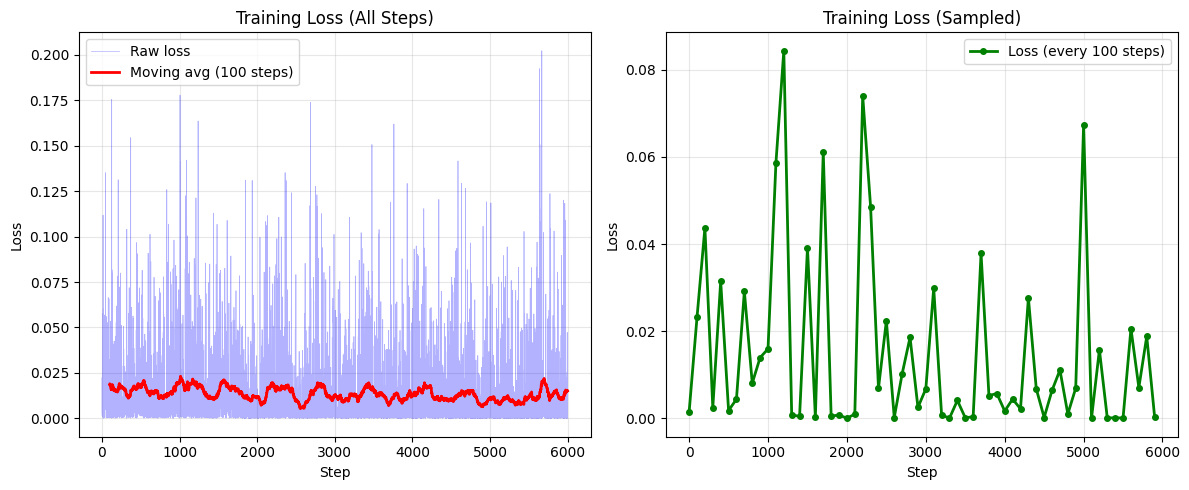

In [14]:
# Train the model with live loss plotting
# The plot will update in real-time as training progresses
losses, steps = train(model, criterion, optimizer, train_loader, 10)

# Optional: Create a final static plot if needed
# plot_loss(losses, steps)

In [17]:
evaluate(model, test_loader)

Accuracy of the network on the 10000 test images: 98.66 %


98.66